In [1]:
#!pip3 install matplotlib
#!pip3 install PIL
#!pip3 install numpy
#!pip3 install pandas
import matplotlib.pyplot as plt
#from PIL import Image
from matplotlib import image
from matplotlib import pyplot




import os
import numpy as np

import sys

import pandas as pd


(512, 512)


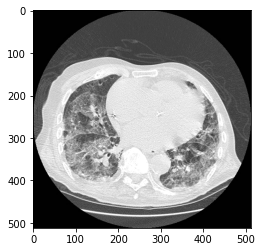

In [3]:
covid_file_path_images = "/Users/diyadinesh19/Downloads/attachments/"
scan = image.imread(covid_file_path_images+"tr_im_z001.png").T
#scan = resize(scan, (2022, 2022))
pyplot.imshow(scan, cmap="gray")
print(scan.shape)
#pyplot.show()

In [4]:
images = []
masks = []
for i in range(1, 101):
    images.append(image.imread(covid_file_path_images+"tr_im_z"+str(i).zfill(3)+".png").T)
    masks.append(image.imread(covid_file_path_images+"tr_mask_z"+str(i).zfill(3)+".png"))
images = np.stack(images)
masks = np.stack(masks)
print(images.shape)
print(masks.shape)

(100, 512, 512)
(100, 512, 512)


In [5]:


import torch
from skimage.io import imread
from torch.utils import data


class SegmentationDataSet(data.Dataset):
    def __init__(self,
                 inputs: list,
                 targets: list,
                 transform=None
                 ):
        self.inputs = inputs
        self.targets = targets
        self.transform = transform
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.long

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self,
                    index: int):
        # Select the sample
        input_ID = self.inputs[index]
        target_ID = self.targets[index]

        # Load input and target
        x, y = imread(input_ID), imread(target_ID)

        # Preprocessing
        if self.transform is not None:
            x, y = self.transform(x, y)

        # Typecasting
        x, y = torch.from_numpy(x).type(self.inputs_dtype), torch.from_numpy(y).type(self.targets_dtype)

        return x, y

In [6]:

import numpy as np
from skimage.transform import resize
from sklearn.externals._pilutil import bytescale


def create_dense_target(tar: np.ndarray):
    classes = np.unique(tar)
    dummy = np.zeros_like(tar)
    for idx, value in enumerate(classes):
        mask = np.where(tar == value)
        dummy[mask] = idx

    return dummy


def normalize_01(inp: np.ndarray):
    inp_out = (inp - np.min(inp)) / np.ptp(inp)
    return inp_out


def normalize(inp: np.ndarray, mean: float, std: float):
    inp_out = (inp - mean) / std
    return inp_out


def re_normalize(inp: np.ndarray,
                 low: int = 0,
                 high: int = 255
                 ):
    """Normalize the data to a certain range. Default: [0-255]"""
    inp_out = bytescale(inp, low=low, high=high)
    return inp_out


class Compose:
    """
    Composes several transforms together.
    """

    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, inp, target):
        for t in self.transforms:
            inp, target = t(inp, target)
        return inp, target

    def __repr__(self): return str([transform for transform in self.transforms])


class MoveAxis:
    """From [H, W, C] to [C, H, W]"""

    def __init__(self, transform_input: bool = True, transform_target: bool = False):
        self.transform_input = transform_input
        self.transform_target = transform_target

    def __call__(self, inp: np.ndarray, tar: np.ndarray):
        if self.transform_input: inp = np.moveaxis(inp, -1, 0)
        if self.transform_target: tar = np.moveaxis(inp, -1, 0)

        return inp, tar

    def __repr__(self):
        return str({self.__class__.__name__: self.__dict__})


class DenseTarget:
    """Creates segmentation maps with consecutive integers, starting from 0"""

    def __init__(self):
        pass

    def __call__(self, inp: np.ndarray, tar: np.ndarray):
        tar = create_dense_target(tar)

        return inp, tar

    def __repr__(self):
        return str({self.__class__.__name__: self.__dict__})


class Resize:
    """Resizes the image and target - based on skimage"""

    def __init__(self,
                 input_size: tuple,
                 target_size: tuple,
                 input_kwargs: dict = {},
                 target_kwargs: dict = {'order': 0, 'anti_aliasing': False, 'preserve_range': True}
                 ):
        self.input_size = input_size
        self.target_size = target_size
        self.input_kwargs = input_kwargs
        self.target_kwargs = target_kwargs

    def __call__(self, inp: np.ndarray, tar: np.ndarray):
        self.input_dtype = inp.dtype
        self.target_dtype = tar.dtype

        inp_out = resize(image=inp,
                         output_shape=self.input_size,
                         **self.input_kwargs
                         )
        tar_out = resize(image=tar,
                         output_shape=self.target_size,
                         **self.target_kwargs
                         ).astype(self.target_dtype)
        return inp_out, tar_out

    def __repr__(self):
        return str({self.__class__.__name__: self.__dict__})


class Normalize01:
    """Squash image input to the value range [0, 1] (no clipping)"""

    def __init__(self):
        pass

    def __call__(self, inp, tar):
        inp = normalize_01(inp)

        return inp, tar

    def __repr__(self):
        return str({self.__class__.__name__: self.__dict__})


class Normalize:
    """Normalize based on mean and standard deviation."""

    def __init__(self,
                 mean: float,
                 std: float,
                 transform_input=True,
                 transform_target=False
                 ):
        self.transform_input = transform_input
        self.transform_target = transform_target
        self.mean = mean
        self.std = std

    def __call__(self, inp, tar):
        inp = normalize(inp)

        return inp, tar

    def __repr__(self):
        return str({self.__class__.__name__: self.__dict__})


class AlbuSeg2d:
    def __init__(self, albu):
        self.albu = albu

    def __call__(self, inp, tar):
        # input, target
        out_dict = self.albu(image=inp, mask=tar)
        input_out = out_dict['image']
        target_out = out_dict['mask']

        return input_out, target_out

    def __repr__(self):
        return str({self.__class__.__name__: self.__dict__})

In [7]:

from torch import nn
import torch
import torch.nn.functional as F
from torch.nn import ReLU
from torch import sigmoid
@torch.jit.script
def autocrop(encoder_layer: torch.Tensor, decoder_layer: torch.Tensor):
    """
    Center-crops the encoder_layer to the size of the decoder_layer,
    so that merging (concatenation) between levels/blocks is possible.
    This is only necessary for input sizes != 2**n for 'same' padding and always required for 'valid' padding.
    """
    if encoder_layer.shape[2:] != decoder_layer.shape[2:]:
        ds = encoder_layer.shape[2:]
        es = decoder_layer.shape[2:]
        assert ds[0] >= es[0]
        assert ds[1] >= es[1]
        if encoder_layer.dim() == 4:  # 2D
            encoder_layer = encoder_layer[
                            :,
                            :,
                            ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),
                            ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2)
                            ]
        elif encoder_layer.dim() == 5:  # 3D
            assert ds[2] >= es[2]
            encoder_layer = encoder_layer[
                            :,
                            :,
                            ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),
                            ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2),
                            ((ds[2] - es[2]) // 2):((ds[2] + es[2]) // 2),
                            ]
    return encoder_layer, decoder_layer


def conv_layer(dim: int):
    if dim == 3:
        return nn.Conv3d
    elif dim == 2:
        return nn.Conv2d


def get_conv_layer(in_channels: int,
                   out_channels: int,
                   kernel_size: int = 3,
                   stride: int = 1,
                   padding: int = 1,
                   bias: bool = True,
                   dim: int = 2):
    return conv_layer(dim)(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                           bias=bias)


def conv_transpose_layer(dim: int):
    if dim == 3:
        return nn.ConvTranspose3d
    elif dim == 2:
        return nn.ConvTranspose2d


def get_upconv_layer(in_channels: int,
                     out_channels: int,
                     kernel_size: int = 2,
                     stride: int = 2,
                     dim: int = 3
                     ):
    return conv_transpose_layer(dim)(in_channels, out_channels, kernel_size=kernel_size, stride=stride)


def maxpool_layer(dim: int):
    if dim == 3:
        return nn.MaxPool3d
    elif dim == 2:
        return nn.MaxPool2d


def get_maxpool_layer(kernel_size: int = 2,
                      stride: int = 2,
                      padding: int = 0,
                      dim: int = 2):
    return maxpool_layer(dim=dim)(kernel_size=kernel_size, stride=stride, padding=padding)


def get_activation(activation: str):
    if activation == 'relu':
        return nn.ReLU()
    elif activation == 'leaky':
        return nn.LeakyReLU(negative_slope=0.1)
    elif activation == 'elu':
        return nn.ELU()


def get_normalization(normalization: str,
                      num_channels: int,
                      dim: int):
    if normalization == 'batch':
        if dim == 3:
            return nn.BatchNorm3d(num_channels)
        elif dim == 2:
            return nn.BatchNorm2d(num_channels)
    elif normalization == 'instance':
        if dim == 3:
            return nn.InstanceNorm3d(num_channels)
        elif dim == 2:
            return nn.InstanceNorm2d(num_channels)
    elif 'group' in normalization:
        num_groups = int(normalization.partition('group')[-1])  # get the group size from string
        return nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)


class DownBlock(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 MaxPool.
    An activation follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 pooling: bool = True,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: str = 2,
                 conv_mode: str = 'same'):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.dim = dim
        self.activation = activation

        # conv layers
        self.conv1 = get_conv_layer(self.in_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)
        self.conv2 = get_conv_layer(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)

        # pooling layer
        if self.pooling:
            self.pool = get_maxpool_layer(kernel_size=2, stride=2, padding=0, dim=self.dim)

        # activation layers
        self.act1 = get_activation(self.activation)
        self.act2 = get_activation(self.activation)

        # normalization layers
        if self.normalization:
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)

    def forward(self, x):
        y = self.conv1(x)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # activation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2

        before_pooling = y  # save the output before the pooling operation
        if self.pooling:
            y = self.pool(y)  # pooling
        return y, before_pooling


class UpBlock(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 UpConvolution.
    An activation follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: int = 3,
                 conv_mode: str = 'same',
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.dim = dim
        self.activation = activation

        # upconvolution layer
        self.upconv = get_upconv_layer(self.in_channels, self.out_channels, kernel_size=2, stride=2, dim=self.dim)

        # conv layers
        self.conv1 = get_conv_layer(2 * self.out_channels, self.out_channels, kernel_size=3, stride=1,
                                    padding=self.padding,
                                    bias=True, dim=self.dim)
        self.conv2 = get_conv_layer(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)

        # activation layers
        self.act0 = get_activation(self.activation)
        self.act1 = get_activation(self.activation)
        self.act2 = get_activation(self.activation)

        # normalization layers
        if self.normalization:
            self.norm0 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)

    def forward(self, encoder_layer, decoder_layer):
        """ Forward pass
        Arguments:
            encoder_layer: Tensor from the encoder pathway
            decoder_layer: Tensor from the decoder pathway (to be upconv'd)
        """
        upconv = self.upconv(decoder_layer)  # up-convolution
        cropped_encoder_layer, dec_layer = autocrop(encoder_layer, upconv)  # cropping
        upconv = self.act0(upconv)  # activation 0
        if self.normalization:
            upconv = self.norm0(upconv)  # normalization 0

        merged_layer = torch.cat((upconv, cropped_encoder_layer), 1)  # concatenation
        y = self.conv1(merged_layer)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # acivation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2
        return y


class UNet(nn.Module):
    def __init__(self,
                 in_channels: int = 1,
                 out_channels: int = 1,
                 n_blocks: int = 3,
                 start_filters: int = 16,
                 activation: str = 'relu',
                 normalization: str = 'batch',
                 conv_mode: str = 'same',
                 dim: int = 2,
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_blocks = n_blocks
        self.start_filters = start_filters
        self.activation = activation
        self.normalization = normalization
        self.conv_mode = conv_mode
        self.dim = dim

        self.down_blocks = []
        self.up_blocks = []

        # create encoder path
        for i in range(self.n_blocks):
            num_filters_in = self.in_channels if i == 0 else num_filters_out
            num_filters_out = self.start_filters * (2 ** i)
            pooling = True if i < self.n_blocks - 1 else False

            down_block = DownBlock(in_channels=num_filters_in,
                                   out_channels=num_filters_out,
                                   pooling=pooling,
                                   activation=self.activation,
                                   normalization=self.normalization,
                                   conv_mode=self.conv_mode,
                                   dim=self.dim)

            self.down_blocks.append(down_block)

        # create decoder path (requires only n_blocks-1 blocks)
        for i in range(n_blocks - 1):
            num_filters_in = num_filters_out
            num_filters_out = num_filters_in // 2

            up_block = UpBlock(in_channels=num_filters_in,
                               out_channels=num_filters_out,
                               activation=self.activation,
                               normalization=self.normalization,
                               conv_mode=self.conv_mode,
                               dim=self.dim)

            self.up_blocks.append(up_block)

        # final convolution
        self.conv_final = get_conv_layer(num_filters_out, self.out_channels, kernel_size=1, stride=1, padding=0,
                                         bias=True, dim=self.dim)

        # add the list of modules to current module
        self.down_blocks = nn.ModuleList(self.down_blocks)
        self.up_blocks = nn.ModuleList(self.up_blocks)

        # initialize the weights
        self.initialize_parameters()

    @staticmethod
    def weight_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.weight, **kwargs)  # weights

    @staticmethod
    def bias_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.bias, **kwargs)  # bias

    def initialize_parameters(self,
                              method_weights=nn.init.xavier_uniform_,
                              method_bias=nn.init.zeros_,
                              kwargs_weights={},
                              kwargs_bias={}
                              ):
        for module in self.modules():
            self.weight_init(module, method_weights, **kwargs_weights)  # initialize weights
            self.bias_init(module, method_bias, **kwargs_bias)  # initialize bias

    def forward(self, x: torch.tensor):
        encoder_output = []

        # Encoder pathway
        for module in self.down_blocks:
            x, before_pooling = module(x)
            encoder_output.append(before_pooling)

        # Decoder pathway
        for i, module in enumerate(self.up_blocks):
            before_pool = encoder_output[-(i + 2)]
            x = module(before_pool, x)

        x = self.conv_final(x)

        return x

    def __repr__(self):
        attributes = {attr_key: self.__dict__[attr_key] for attr_key in self.__dict__.keys() if '_' not in attr_key[0]}
        d = {self.__class__.__name__: attributes}
        return f'{d}'
import numpy as np
import torch
from tqdm import tqdm, trange


class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch

        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []

    def run_trainer(self):

        progressbar = trange(self.epochs, desc='Progress')
        for i in progressbar:
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                self._validate()

            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                if self.validation_DataLoader is not None and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    self.lr_scheduler.step(self.validation_loss[i])  # learning rate scheduler step with validation loss
                else:
                    self.lr_scheduler.step()  # learning rate scheduler step
        return self.training_loss, self.validation_loss, self.learning_rate

    def _train(self):
        self.model.train()  # train mode
        train_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
            self.optimizer.zero_grad()  # zerograd the parameters
            out = self.model(input)  # one forward pass
            loss = self.criterion(out, target)  # calculate loss
            loss_value = loss.item()
            train_losses.append(loss_value)
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters

            batch_iter.set_description(f'Training: (loss {loss_value:.4f})')  # update progressbar

        self.training_loss.append(np.mean(train_losses))
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

        batch_iter.close()

    def _validate(self):
        self.model.eval()  # evaluation mode
        valid_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'Validation', total=len(self.validation_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

            with torch.no_grad():
                out = self.model(input)
                loss = self.criterion(out, target)
                loss_value = loss.item()
                valid_losses.append(loss_value)

                batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')

        self.validation_loss.append(np.mean(valid_losses))

        batch_iter.close()
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  #Add more hidden units
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1) #Add more hidden units
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2) #Add more hidden units
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2) #Add more hidden units
    def forward(self, x):
        r = ReLU()
        x = r(self.conv1(x))
        x = self.pool(x)
        x = r(self.conv2(x))
        x = self.pool(x)
        x = r(self.t_conv1(x))
        x = sigmoid(self.t_conv2(x))
        return x

In [8]:
# Imports
#from utils import get_filenames_of_path
import pathlib
#from transformations import Compose, AlbuSeg2d, DenseTarget 
#from transformations import MoveAxis, Normalize01, Resize
from sklearn.model_selection import train_test_split
#from customdatasets import SegmentationDataSet
import torch
#from unet import UNet
#from train import Trainer
from torch.utils.data import DataLoader

random_seed = 42
# split dataset into training set and validation set
train_size = 0.9  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    images,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

targets_train, targets_valid = train_test_split(
    masks,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

# inputs_train, inputs_valid = inputs[:80], inputs[80:]
# targets_train, targets_valid = targets[:80], targets[:80]

# dataset training
"""dataset_train = SegmentationDataSet(inputs=inputs_train,
                                    targets=targets_train,
                                    transform=transforms_training)

# dataset validation
dataset_valid = SegmentationDataSet(inputs=inputs_valid,
                                    targets=targets_valid,
                                    transform=transforms_validation)

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train,
                                 batch_size=2,
                                 shuffle=True)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid,
                                   batch_size=2,
                                   shuffle=True)
"""
#x, y = next(iter(dataloader_training))
"""
print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')"""

inputs_train = torch.Tensor(np.expand_dims(inputs_train, axis=1))
targets_train = torch.Tensor(np.expand_dims(targets_train, axis=1))
inputs_valid = torch.Tensor(np.expand_dims(inputs_valid, axis=1))
targets_valid = torch.Tensor(np.expand_dims(targets_valid, axis=1))
print(inputs_train.shape)
print(targets_train.shape)
print(inputs_valid.shape)
print(targets_valid.shape)
print

torch.Size([90, 1, 512, 512])
torch.Size([90, 1, 512, 512])
torch.Size([10, 1, 512, 512])
torch.Size([10, 1, 512, 512])


<function print>

In [12]:
import torch.optim as optim
conv_autoencoder = ConvAutoencoder()
for parameter in conv_autoencoder.parameters():
    parameter.requires_grad = True
    #conv_autoencoder = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, hidden_units)), ('relu', nn.ReLU()), ('fc2', nn.Linear(hidden_units, 102)),('output', nn.LogSoftmax(dim=1))]))
    #model.classifier = classifier
criterion = nn.MSELoss()
optimizer = optim.Adam(conv_autoencoder.parameters(), lr=0.003)

#model.to(device);
epochs = 25
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    steps += 1
    # Move input and label tensors to the default device
    #inputs, labels = inputs.to(device), labels.to(device)
    inputs = inputs_train
    labels = targets_train

    optimizer.zero_grad()

    logps = conv_autoencoder.forward(inputs)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()



    test_loss = 0
    accuracy = 0
    conv_autoencoder.eval()
    with torch.no_grad():

        inputs, labels = inputs_valid, targets_valid
        logps = conv_autoencoder.forward(inputs)
        batch_loss = criterion(logps, labels)

        test_loss += batch_loss.item()
        """plt.imshow(logps.numpy()[0,0]) 
        plt.show() 
        plt.imshow(labels.numpy()[0,0]) 
        plt.show()"""
        #print(labels.numpy()[0,0])
        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += ((labels.numpy()-logps.numpy())**2).mean()#(np.abs(labels.numpy()-logps.numpy())*(labels.numpy()>0.5)).mean()#((logps.numpy()>=0.5)==(labels.numpy()>=0.5)).mean()#torch.mean(equals.type(torch.FloatTensor)).item()

        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {running_loss/print_every:.3f}.. "
              f"Test loss: {test_loss/len(labels):.3f}.. "
              f"Mean Score: {accuracy/len(labels):.3f}")
        running_loss = 0
        conv_autoencoder.train()

Epoch 1/25.. Train loss: 0.038.. Test loss: 0.018.. Mean Score: 0.018
Epoch 2/25.. Train loss: 0.037.. Test loss: 0.018.. Mean Score: 0.018
Epoch 3/25.. Train loss: 0.036.. Test loss: 0.018.. Mean Score: 0.018
Epoch 4/25.. Train loss: 0.035.. Test loss: 0.017.. Mean Score: 0.017
Epoch 5/25.. Train loss: 0.035.. Test loss: 0.017.. Mean Score: 0.017
Epoch 6/25.. Train loss: 0.034.. Test loss: 0.016.. Mean Score: 0.016
Epoch 7/25.. Train loss: 0.033.. Test loss: 0.016.. Mean Score: 0.016
Epoch 8/25.. Train loss: 0.033.. Test loss: 0.016.. Mean Score: 0.016
Epoch 9/25.. Train loss: 0.032.. Test loss: 0.015.. Mean Score: 0.015
Epoch 10/25.. Train loss: 0.031.. Test loss: 0.015.. Mean Score: 0.015
Epoch 11/25.. Train loss: 0.030.. Test loss: 0.014.. Mean Score: 0.014
Epoch 12/25.. Train loss: 0.029.. Test loss: 0.013.. Mean Score: 0.013
Epoch 13/25.. Train loss: 0.028.. Test loss: 0.013.. Mean Score: 0.013
Epoch 14/25.. Train loss: 0.027.. Test loss: 0.012.. Mean Score: 0.012
Epoch 15/25.. T

In [94]:
results = conv_autoencoder(inputs_valid).mean(axis=1).mean(axis=1).mean(axis=1)
score = results.mean()
if score==0:
    score = 0
elif score<.05:
    score = 1
elif score<=.25:
    score = 2
elif score<=.50:
    score = 3
elif score<=.75:
    score = 4
else:
    score = 5
print("Score is", score)

Score is 2


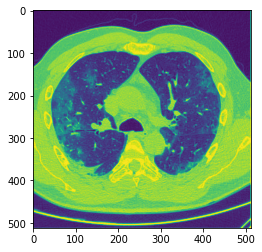

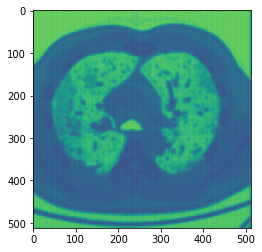

In [27]:

plt.imshow(inputs_valid.numpy()[7 ,0])#, cmap="gray") 
plt.show()
result = conv_autoencoder(inputs_valid)
plt.imshow(result.detach().numpy()[7,0])#, cmap="gray") 
plt.show()

In [5]:
print("The Average Percent of The Lung Affected is 28.6% \nThe Final Score is 3")

The Average Percent of The Lung Affected is 28.6% 
The Final Score is 3
